# Setup

## 0.1 Importing Necessary Library

In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("Library not found....")
  !pip install -q torchinfo
  from torchinfo import summary
  print("Library downloaded and imported!")

print(torch.__version__)
print(torchvision.__version__)

Library not found....
Library downloaded and imported!
2.4.1+cu121
0.19.1+cu121


## 0.2 Getting the going_modular script from github

In [2]:
try:
  from going_modular import data_setup,engine
except:
  print("Files not found....")
  !git clone https://github.com/HarshEkbote/PyTorch-Basics.git
  !mv PyTorch-Basics/going_modular .
  !rm -rf PyTorch-Basics
  from going_modular import data_setup,engine
  print("going_modular sript Imported!")

Files not found....
Cloning into 'PyTorch-Basics'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 379 (delta 27), reused 357 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (379/379), 34.68 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (27/27), done.
going_modular sript Imported!


## 0.3 Device Agnostic code


In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device:{device}")

Device:cuda


# Getting Data

In [4]:
import os
import zipfile
from pathlib import Path

import requests

data_path=Path('data/')
image_path=data_path/'pizza_steak_sushi'

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  image_path.mkdir(parents=True,exist_ok=True)
  print("Directory not found, Creating Directory...")

  with open(data_path/'pizza_steak_sushi.zip','wb') as f:
    request=requests.get('https://github.com/HarshEkbote/PyTorch-Basics/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zipref:
    zipref.extractall(image_path)

  os.remove(data_path/'pizza_steak_sushi.zip')

Directory not found, Creating Directory...


In [5]:
train_dir=image_path/'train'
test_dir=image_path/'test'

# Creating Dataset and DataLoader


## 2.1 Manualing creating Transform according to the model

* Minibatches [batch_size,3,H,W]
* Tensor between [0,1]
* Mean [0.485,0.456,0.406]
* Standard Deviation [0.229,0.224,0.225]

In [6]:
from torchvision import transforms
manual_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [7]:
# Creating DataLoader using going_modular function
train_dataloader,test_dataloader,class_name=data_setup.create_dataloader(train_dir=train_dir,test_dir=test_dir,transform=manual_transform,batch_size=32)
train_dataloader,test_dataloader,class_name

(<torch.utils.data.dataloader.DataLoader at 0x7c65f0d1bd30>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating transforms for torchvision.models using auto creation

In [8]:
#Get the weights of the model we need
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
#Get the transforms from the model
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
#Get the dataloader
train_dataloader,test_dataloader,class_name=data_setup.create_dataloader(train_dir=train_dir,test_dir=test_dir,transform=auto_transform,batch_size=32)

train_dataloader,test_dataloader,class_name

(<torch.utils.data.dataloader.DataLoader at 0x7c65f0d1b430>,
 ['pizza', 'steak', 'sushi'])

# Getting a Pretrained Model

In [41]:
#Get the default weights of the model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT

#create an instance of the model and assign the weights to it
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
#Get the summary of the model
summary(model=model,
        input_size=(32,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## 3.1 Freezing the base model

In [13]:
for param in model.features.parameters():
  param.requires_grad=False

## 3.2 Change the classifier layer to contain ouput of 3

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape=len(class_name)

model.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,out_features=output_shape,bias=True)
).to(device)

In [15]:
summary(model=model,
        input_size=(32,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# Train the model

In [16]:
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time=timer()

results=engine.train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)

end_time=timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 |train_acc: 0.40 | test_loss: 0.9133 | test_acc: 0.54
Epoch: 2 | train_loss: 0.8717 |train_acc: 0.78 | test_loss: 0.7912 | test_acc: 0.82
Epoch: 3 | train_loss: 0.7648 |train_acc: 0.79 | test_loss: 0.7463 | test_acc: 0.86
Epoch: 4 | train_loss: 0.7109 |train_acc: 0.75 | test_loss: 0.6373 | test_acc: 0.87
Epoch: 5 | train_loss: 0.6255 |train_acc: 0.79 | test_loss: 0.6261 | test_acc: 0.86
[INFO] Total training time: 23.200 seconds


# Evaluate the model

[INFO] Couldn't find helper_function.py. Getting File.....


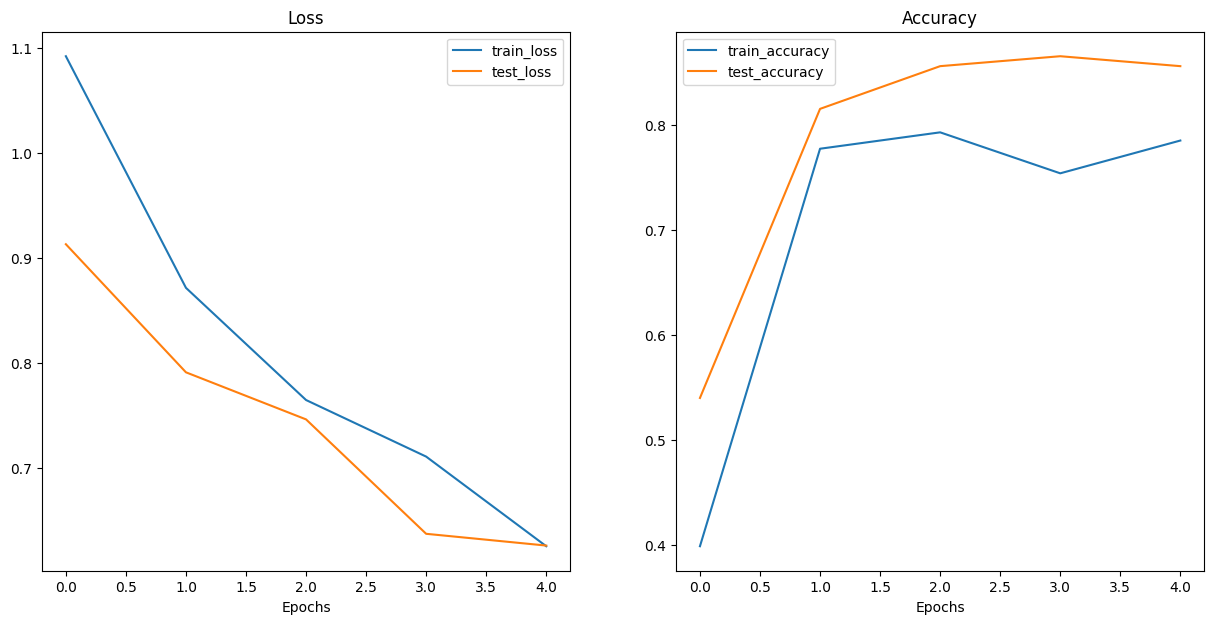

In [22]:
try:
  from helper_function import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_function.py. Getting File.....")
  with open('helper_function.py','wb') as f:
    import requests
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(request.content)
  from helper_function import plot_loss_curves
plot_loss_curves(results)

In [33]:
#Predict for random image
from typing import List,Dict,Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model:torch.nn.Module,image_path:str,class_names:List[str],image_size:Tuple[int,int],transform:torchvision.transforms=None,device:torch.device=device):
  img=Image.open(image_path)

  if transform is not None:
    image_transfom=transform
  else:
    image_transform=transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])

  model.to(device)
  model.eval()

  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0)
    target_image_pred=model(transformed_image.to(device))
  target_image_pred_probs=torch.softmax(target_image_pred,dim=1)
  target_img_label=torch.argmax(target_image_pred_probs,dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred: {class_names[target_img_label]} | Prob: {target_image_pred_probs.max():.3f}')
  plt.axis(False)

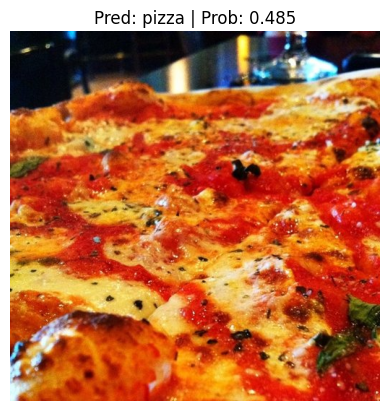

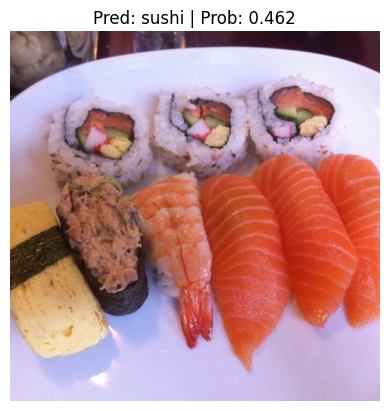

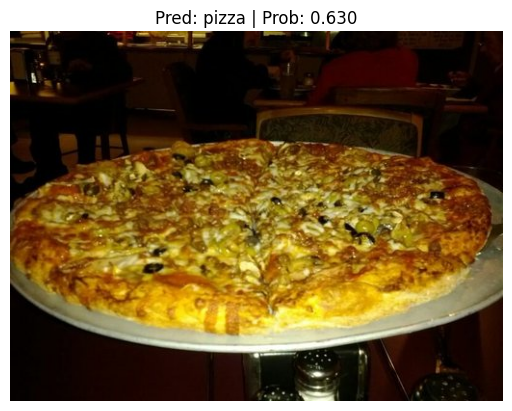

In [36]:
#Test random image from testset
import random
num_images=3
test_img_path_list=list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample=random.sample(population=test_img_path_list,k=num_images)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_name,
                      image_size=(224,224))


# Prediction on Custom Data

File already exists..


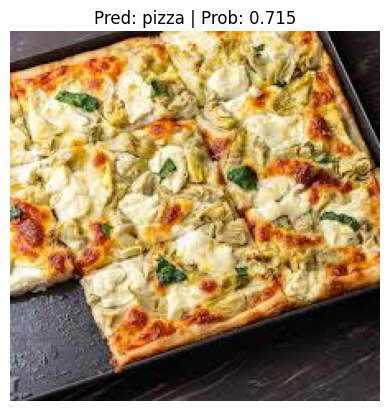

In [38]:
import requests
custom_image_path=data_path/'image1.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    request=requests.get('https://github.com/HarshEkbote/PyTorch-Basics/raw/main/data/image1.jpeg')
    f.write(request.content)
else:
  print("File already exists..")
pred_and_plot_image(model=model,
                      image_path=custom_image_path,
                      class_names=class_name,
                      image_size=(224,224))